## Milestone Project 2: SkimLit 📄🔥
The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

📖 Resource: If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Get data
Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
import os
#import tf_keras
os.environ['TF_USE_LEGACY_KERAS']='1'
os.environ['TF_USE_LEGACY_KERAS']

'1'

In [2]:
import tensorflow as tf

tf.__version__

2024-09-10 17:45:14.738228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 17:45:14.761113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 17:45:14.768178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 17:45:14.785244: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 17:45:16.089899: W tensorflow/compiler/tf2

'2.17.0'

In [3]:
#tf_keras.__version__

In [4]:
#tf.keras.__version__

In [5]:
#!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

In [6]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [7]:
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [8]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir='pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [9]:
# Check all of the filenames in the target directory
import os

filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data
Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

>Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [10]:
# Create function to read the lines of a document
def get_lines(filename):
    with open(filename, 'r') as f:
        return f.readlines()


In [11]:
# Let's read in the training lines
train_lines= get_lines(data_dir + 'train.txt')

In [12]:
data_dir

'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [13]:
len(train_lines)

210040

In [14]:
for i, sentence in enumerate(train_lines[:20]):
    print(f'{i}\t {sentence}')

0	 ###24293578

1	 OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

2	 METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .

3	 METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

4	 METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .

5	 METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .

6	 METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity 

In [15]:
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look...

How I think our data would be best represented...
```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```
Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [16]:
type(train_lines)

list

In [17]:
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Takes in filename, reads it contents and sorts through each line,
    extracting things like the target label, the text of the sentnece,
    how many sentences are in the current abstract and what sentence
    number the target line is.
    
    Args:
        filename: a string of the target text file to read and extract line data
        from.

    Returns:
        A list of dictionaries each containing a line from an abstract,
        the lines label, the lines position in the abstract and the total number
        of lines in the abstract where the line is from. For example:

        [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
    """
    input_lines= get_lines(filename) # get all lines from filename
    abstract_lines="" # create an empty abstract 
    abstract_samples=[] # create an empty list of abstracts
    
    # Loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'): # check to see if this is an ID line
            #abstract_id= line # set the abstract ID
            abstract_lines="" # reset the abstract string
        
        elif line.isspace(): # check to see if line is a new line
            abstract_lines_split= abstract_lines.splitlines() # split abstract into separate lines
            
            # Iterate through each line in abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_lines_split):
                line_data={} # create an empty dictionary for each line
                target_text_split= abstract_line.split('\t') # split target label from text
                line_data['target']= target_text_split[0] # get target label
                line_data['text']= target_text_split[1].lower() # get the target text and lower it
                line_data['line_number']= abstract_line_number
                line_data['total_lines']= len(abstract_lines_split)-1
                
                abstract_samples.append(line_data)
        
        else: #  if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line
                
    return abstract_samples

In [18]:
a='###25552432' 
b='\n'
a.isalpha(), b.isalpha()

(False, False)

In [19]:
a='water\n'
a.isalpha()

False

In [20]:
a='water\n'
a.isspace()

False

In [21]:
a='\n'
a.isspace()

True

In [22]:
a='How yo doing\nIm ok'
a.splitlines()

['How yo doing', 'Im ok']

In [23]:
a={}
a['a']=1
a[2]=2
a

{'a': 1, 2: 2}

In [24]:
# Get data from file and preprocess it
%time

train_samples= preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples= preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples= preprocess_text_with_line_numbers(data_dir + 'test.txt')

len(train_samples) , len(val_samples), len(test_samples)

CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 11.4 μs


(180040, 30212, 30135)

In [25]:
# Check the first abstract of our training data
(train_samples[:12])

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [26]:
# Turning dictionaries intp dataframes to further visualizing
import pandas as pd
train_df= pd.DataFrame(train_samples)
val_df= pd.DataFrame(val_samples)
test_df= pd.DataFrame(test_samples)

In [27]:
train_df[:12]

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [28]:
# Distribution of labels in training dataset
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [29]:
# Length of different lines
train_df.total_lines.value_counts().sort_index()

total_lines
3        32
4       215
5      1146
6      3353
7      7464
8     12285
9     19400
10    23639
11    24468
12    22113
13    18438
14    14610
15    10768
16     7429
17     5202
18     3344
19     2480
20     1281
21      770
22      759
23      264
24      200
25      182
26       81
27       28
28       58
30       31
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

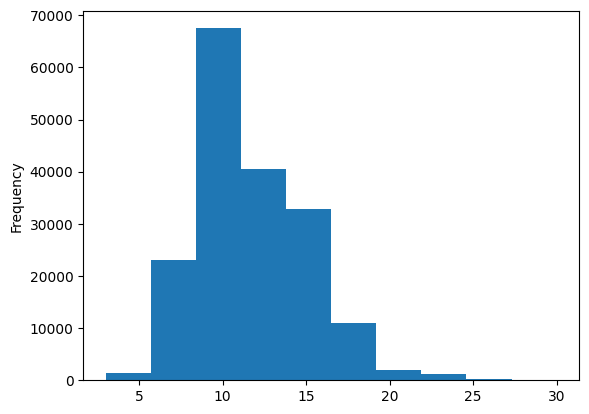

In [30]:
train_df.total_lines.plot(kind='hist')

<Axes: ylabel='total_lines'>

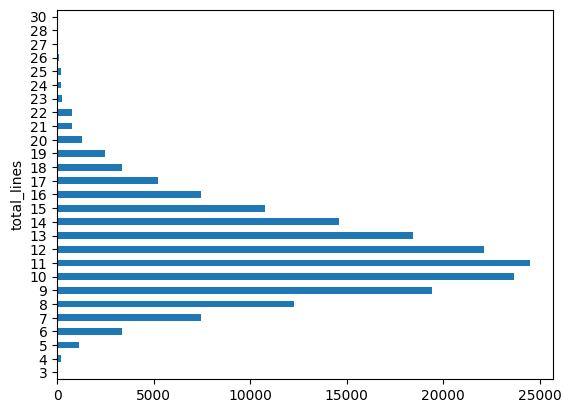

In [31]:
train_df.total_lines.value_counts().sort_index().plot.barh()

### Get lists of sentences

In [32]:
# Convert abstract text lines to lists
train_sentences= train_df['text'].to_list()
val_sentences= val_df['text'].to_list()
test_sentences= test_df['text'].to_list()

In [33]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [34]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder= OneHotEncoder(sparse_output=False)
train_labels_one_hot= one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot= one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot= one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [35]:
one_hot_encoder.categories_

[array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object)]

In [36]:
train_df['target'].shape, train_df['target'].to_numpy().reshape(-1,1).shape

((180040,), (180040, 1))

In [37]:
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [38]:
train_df['target'].value_counts().shape

(5,)

In [39]:
import tensorflow as tf

tf.constant(train_labels_one_hot)

2024-09-10 17:45:35.052864: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

### Label encode labels

In [40]:
train_labels_one_hot.dtype

dtype('float64')

In [41]:
type(train_labels_one_hot)

numpy.ndarray

In [42]:
# Extract labels ("target" columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder

label_encoder= LabelEncoder()
train_labels_encoded= label_encoder.fit_transform(train_df['target'])
val_labels_encoded= label_encoder.transform(val_df['target'])
test_labels_encoded= label_encoder.transform(test_df['target'])

In [43]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [44]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [45]:
num_classes= len(label_encoder.classes_)
class_names= label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modeling experiments

## Model 0: base line TF-IDF Multinomial Naive Bayes classifier

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0= Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [47]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [48]:
baseline_preds= model_0.predict(test_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

In [49]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-09-10 17:45:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Connecting to 127.0.0.1:12334... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.9’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-09-10 17:45:44 (44.4 MB/s) - ‘helper_functions.py.9’ saved [10246/10246]



In [50]:
from helper_functions import calculate_results

baseline_results= calculate_results(test_labels_encoded, baseline_preds)
baseline_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Preparing our data for deep sequence models

In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding


In [52]:
word_len=[len(sentence.split()) for sentence in train_sentences]
    
word_len_avg= np.mean(word_len) 
word_len_avg

26.338269273494777

(array([1.1050e+03, 3.5170e+03, 7.7850e+03, 1.3079e+04, 1.6589e+04,
        1.8463e+04, 1.8770e+04, 1.7656e+04, 1.5580e+04, 1.3302e+04,
        1.1002e+04, 9.0040e+03, 7.0390e+03, 5.5540e+03, 4.2780e+03,
        3.3890e+03, 2.7020e+03, 2.1960e+03, 1.7050e+03, 9.5300e+02,
        1.1780e+03, 9.0000e+02, 7.5000e+02, 6.0900e+02, 4.9400e+02,
        4.0100e+02, 3.5000e+02, 2.5000e+02, 2.2900e+02, 2.1500e+02,
        1.6700e+02, 1.2600e+02, 1.0200e+02, 1.0100e+02, 6.4000e+01,
        6.1000e+01, 5.5000e+01, 4.5000e+01, 4.0000e+01, 2.5000e+01,
        2.5000e+01, 2.4000e+01, 2.2000e+01, 1.4000e+01, 1.6000e+01,
        1.0000e+01, 7.0000e+00, 1.6000e+01, 7.0000e+00, 5.0000e+00,
        3.0000e+00, 5.0000e+00, 5.0000e+00, 6.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 1.00

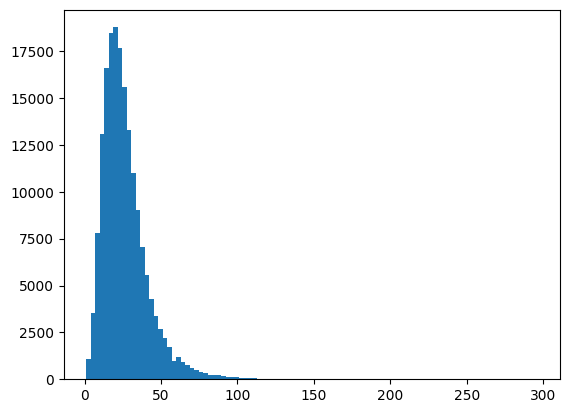

In [53]:
import matplotlib.pyplot as plt

plt.hist(word_len, bins=100)

In [54]:
np.min(word_len), np.max(word_len)

(1, 296)

In [55]:
output_seq_len= int(np.quantile(word_len, .95))
output_seq_len


55

In [56]:
np.percentile(word_len, 95)

55.0

### Create text vectorizer layer
We want to make a layer which maps our texts from words to numbers.

In [57]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000
  

In [58]:
text_vectorizer= TextVectorization(max_tokens=max_tokens,
                                  output_mode='int',
                                  output_sequence_length= output_seq_len
                                  )

In [59]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [60]:
text_vectorizer(train_sentences[0])

<tf.Tensor: shape=(55,), dtype=int64, numpy=
array([   6,  331,    2,   79,    4,   53,    4,  161, 1127,  217, 2535,
          5,  557,   65, 1584,    3,  670, 5559,  636,    5,    2,  654,
       1137,    3,  180,    2,   70,  495,   36,  781,   15,   53,    5,
        350,  266,    7,  362,    6,  289,  517, 1430, 1743,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])>

In [61]:
import random

random_sentence= random.choice(train_sentences)
print(f'Text:\n{random_sentence}',
     f'\n\nLength:\t{len(random_sentence.split())}',
     f'\n\nVectorized text:\n{text_vectorizer(random_sentence)}')

Text:
a higher preference ( chi-square , p = @ ) for e. mulungu was observed for both genders . 

Length:	19 

Vectorized text:
[    8    82  1845  2960    14    11   949 29948    10   148    11    54
  7220     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [62]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [63]:
text_vectorizer.vocabulary_size()

64841

In [64]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding layer

In [65]:
token_embedding= Embedding(input_dim=len(rct_20k_text_vocab),
                         output_dim=128,
                         mask_zero=True,
                         name= 'token_embedding')

In [66]:
vectorized_random_sentence= text_vectorizer(random_sentence) 
embedded_random_sentence= token_embedding(vectorized_random_sentence)

print(f'Sentence before vectorization:\n{random_sentence}'
      f'\nLen: {len(random_sentence.split())}'
      
     f'\n\nSentence after vectorization:\n{vectorized_random_sentence} '
     f'\nLen: {vectorized_random_sentence.shape}'
     
     f'\n\nSentence after embedding:\n{embedded_random_sentence}'
     f'\nLen: {embedded_random_sentence.shape}')

Sentence before vectorization:
a higher preference ( chi-square , p = @ ) for e. mulungu was observed for both genders .
Len: 19

Sentence after vectorization:
[    8    82  1845  2960    14    11   949 29948    10   148    11    54
  7220     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0] 
Len: (55,)

Sentence after embedding:
[[ 0.02618775 -0.01092144  0.01663447 ... -0.02367148 -0.03830415
   0.00765042]
 [ 0.00204182 -0.02576964  0.02923802 ... -0.0136838   0.02209704
  -0.01868911]
 [ 0.01594212  0.01127898 -0.02155893 ...  0.01623939  0.01697545
   0.04398756]
 ...
 [-0.01536334  0.00362496 -0.03177564 ...  0.04927814  0.02636642
  -0.01366482]
 [-0.01536334  0.00362496 -0.03177564 ...  0.04927814  0.02636642
  -0.01366482]
 [-0.01536334  0.00362496 -0.03177564 ...  0.04927814  

## Creating datasets (making sure our data loads as fast as possible)
We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:

- https://www.tensorflow.org/guide/data_performance
- https://www.tensorflow.org/guide/data

In [67]:
# Turn out data into TensorFlow datasets
train_dataset= tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset= tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset= tf.data.Dataset.from_tensor_slices( (test_sentences, test_labels_one_hot))

In [68]:
len(train_dataset)

180040

In [69]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [70]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset= train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset= val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset= test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# We don't need to shuffle dataset because we want the model to leans the order 

In [71]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Cond1D with token embedings

In [72]:
from tf_keras import layers

inputs= layers.Input(shape=(1,), dtype=tf.string)
vectors= text_vectorizer(inputs)
embeddings= token_embedding(vectors)
x= layers.Conv1D(64, 5, padding='same', activation='relu')(embeddings)
x= layers.GlobalAvgPool1D()(x)
outputs= layers.Dense(num_classes, activation='softmax')(x)
model_1= tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [73]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [74]:
num_classes

5

In [75]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [76]:
len(train_dataset), len(train_sentences)

(5627, 180040)

In [77]:
len(train_sentences)/len(train_dataset)

31.99573484983117

In [78]:
int(0.1 * len(train_dataset))

562

In [79]:
history_model_1= model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1 * len(train_dataset)), # only train on 10% of batches
                            epochs=3,
                            validation_data= val_dataset,
                            validation_steps= int(.1 * len(val_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 60s 106ms/step - loss: 0.9193 - accuracy: 0.6341 - val_loss: 0.6878 - val_accuracy: 0.7407
Epoch 2/3
562/562 [==============================] - 58s 102ms/step - loss: 0.6617 - accuracy: 0.7536 - val_loss: 0.6337 - val_accuracy: 0.7703
Epoch 3/3
562/562 [==============================] - 57s 102ms/step - loss: 0.6231 - accuracy: 0.7720 - val_loss: 0.6006 - val_accuracy: 0.7859


In [80]:
model_1.evaluate(test_dataset)

942/942 [==============================] - 4s 4ms/step - loss: 0.6166 - accuracy: 0.7815


[0.6166027784347534, 0.7814833521842957]

In [81]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs= model_1.predict(test_dataset)
model_1_pred_probs[:10]

942/942 [==============================] - 4s 4ms/step


array([[3.6234576e-01, 6.6131987e-02, 2.6218015e-01, 2.8357592e-01,
        2.5766125e-02],
       [2.0421096e-03, 1.2576473e-03, 9.6830654e-01, 2.4011591e-03,
        2.5992420e-02],
       [5.9552968e-04, 2.3932867e-03, 8.3795661e-01, 3.1123369e-04,
        1.5874329e-01],
       [3.2604625e-04, 4.3787289e-04, 9.3146861e-01, 6.2067795e-04,
        6.7146726e-02],
       [1.0146103e-03, 4.5000814e-02, 1.1016395e-02, 4.5483711e-04,
        9.4251323e-01],
       [3.1491505e-09, 4.0094375e-05, 1.1499808e-06, 8.9872576e-10,
        9.9995869e-01],
       [3.6805704e-07, 1.5929593e-04, 3.8150602e-04, 9.3146667e-08,
        9.9945867e-01],
       [5.6286764e-01, 1.6143790e-01, 5.2333083e-03, 2.6850477e-01,
        1.9564333e-03],
       [2.6393810e-01, 5.1236528e-01, 3.4540374e-02, 1.3626306e-01,
        5.2893307e-02],
       [3.4106049e-01, 3.9755058e-01, 4.7053741e-03, 2.5408098e-01,
        2.6025523e-03]], dtype=float32)

In [82]:
model_1_preds= tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 2, 2, 2, 4, 4, 4, 0, 1, 1])>

In [83]:
model_1_results= calculate_results(test_labels_encoded, model_1_preds)
model_1_results

{'accuracy': 78.1483325037332,
 'precision': 0.7785987243095172,
 'recall': 0.781483325037332,
 'f1': 0.7790050365957764}

In [84]:
baseline_results

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

## Model 2: Feature extraction with pretrained token embeddings

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.



In [85]:
import tensorflow_hub as hub

tf_hub_embedding_layer= hub.KerasLayer("tensorflow_hub/universal-sentence-encoder/",
                                       trainable=False,
                                       input_shape=[],
                                       output_shape=[],
                                       dtype='string',
                                       name='universal_sentence_encoder' 
                                       )

In [86]:
tf_hub_embedding_layer

In [87]:
random_sentence= random.choice(train_sentences)
print(f'Random train sentence:'
      f'\nShape: {len(random_sentence.split())}'
      f'\n{random_sentence}')

random_sentence_use= tf_hub_embedding_layer([random_sentence])
print(f'\nAfter passing through Universal Sentence Encoder:'
      f'\nShape: {random_sentence_use.shape}'
      f'\n{random_sentence_use}')

Random train sentence:
Shape: 12
a stratified-block randomized controlled multicenter trial was designed for this study .

After passing through Universal Sentence Encoder:
Shape: (1, 512)
[[ 0.03313299  0.03058615  0.00038158 -0.02143525 -0.04267887  0.0118019
   0.04846274 -0.01298285  0.07977622  0.00756513  0.0573509   0.02112124
   0.09047729  0.04089547 -0.00538897 -0.00197658 -0.03336632  0.07443674
   0.04609964 -0.07538683 -0.0771336   0.01900086 -0.07444838 -0.03956249
   0.01956215 -0.02580973  0.05154924  0.0687549   0.00604931 -0.00474414
   0.06586796  0.03844732 -0.0454361   0.05740369 -0.03791422  0.04999524
  -0.08693098 -0.04602776  0.01643779  0.02967106 -0.06954911  0.07200667
  -0.06143852 -0.00216977 -0.0334749   0.04623605 -0.03508041  0.0520578
   0.01264876 -0.04238234  0.01424803 -0.06384389  0.03055163 -0.01266206
   0.027103   -0.01792813  0.08496539 -0.01358143  0.06788569  0.03053904
  -0.03532942  0.05033947  0.03848899 -0.06001144  0.04311215  0.03225929

In [88]:
random_sentence_use[0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.033132993>

### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [89]:
import tf_keras

In [90]:
inputs= tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding= tf_hub_embedding_layer(inputs)
x= tf.keras.layers.Dense(128, activation='relu')(pretrained_embedding)
outputs= tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_2= tf.keras.Model(inputs, outputs,
                       name='model_2_use_feature_extractor')

model_2.compile(loss=tf_keras.losses.CategoricalCrossentropy(),
               optimizer= tf_keras.optimizers.Adam(),
               metrics= ['accuracy'])

In [91]:
model_2.summary()

Model: "model_2_use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [92]:
history_model_2= model_2.fit(train_dataset,
                            steps_per_epoch= int(0.1 * len(train_dataset)),
                            epochs=3,
                            validation_data= val_dataset,
                            validation_steps= int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 11ms/step - loss: 0.9180 - accuracy: 0.6477 - val_loss: 0.7938 - val_accuracy: 0.6912
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 0.7659 - accuracy: 0.7025 - val_loss: 0.7518 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 6s 12ms/step - loss: 0.7477 - accuracy: 0.7133 - val_loss: 0.7357 - val_accuracy: 0.7134


In [93]:
model_2.evaluate(test_dataset)

942/942 [==============================] - 8s 8ms/step - loss: 0.7506 - accuracy: 0.7082


[0.7506044507026672, 0.7081798315048218]

In [94]:
model_2_pred_probs= model_2.predict(test_dataset)

942/942 [==============================] - 8s 8ms/step


In [95]:
model_2_pred_probs[:5]

array([[3.7407893e-01, 1.0385188e-01, 4.2053547e-02, 4.4924873e-01,
        3.0766876e-02],
       [2.8498602e-01, 4.3923065e-02, 8.7473467e-02, 5.6775254e-01,
        1.5864944e-02],
       [1.1216059e-03, 7.0089144e-03, 8.7445611e-01, 1.6274982e-03,
        1.1578587e-01],
       [8.3121080e-03, 1.6399471e-02, 4.9132985e-01, 2.4390161e-02,
        4.5956844e-01],
       [6.5435859e-04, 3.1233126e-02, 4.4538807e-02, 4.4880027e-04,
        9.2312497e-01]], dtype=float32)

In [96]:
model_2_preds= tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 3, 2, 2, 4])>

In [97]:
model_2_results=calculate_results(test_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 70.81798573087772,
 'precision': 0.7106493391371064,
 'recall': 0.7081798573087772,
 'f1': 0.7055737267535206}

In [98]:
model_1_results

{'accuracy': 78.1483325037332,
 'precision': 0.7785987243095172,
 'recall': 0.781483325037332,
 'f1': 0.7790050365957764}

## Model 3: Conv1D with character embeddings
The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [99]:
a='Mohammad'
' '.join(a)

'M o h a m m a d'

In [100]:
a=['Mohammad','Hossein','Abedi']
for i in a:
    print(' '.join(i))

M o h a m m a d
H o s s e i n
A b e d i


In [101]:
def split_character(text):
    return ' '.join(list(text))


In [102]:
split_character('Mohammad Hossein Abedi')

'M o h a m m a d   H o s s e i n   A b e d i'

In [103]:
[' '.join(i) for i in ['Mohammad','Hossein','Abedi']]

['M o h a m m a d', 'H o s s e i n', 'A b e d i']

In [104]:
[' '.join(i).split() for i in ['Mohammad','Hossein','Abedi']]

[['M', 'o', 'h', 'a', 'm', 'm', 'a', 'd'],
 ['H', 'o', 's', 's', 'e', 'i', 'n'],
 ['A', 'b', 'e', 'd', 'i']]

In [105]:
[split_character(i) for i in ['Mohammad','Hossein','Abedi']]

['M o h a m m a d', 'H o s s e i n', 'A b e d i']

In [106]:
train_chars= [split_character(i) for i in train_sentences]
val_chars= [split_character(i) for i in val_sentences]
test_chars= [split_character(i) for i in test_sentences]

In [107]:
train_chars[0], val_chars[0], test_chars[0]

('t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'i g e   s e n s i t i z a t i o n   t o   a s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 't h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t 

In [108]:
len(train_chars[0])

561

In [109]:
len(train_chars[0].split())

233

In [110]:
# Whats the average charater length?
char_len= [len(i) for i in train_chars]

In [111]:
char_len[:10]

[561, 273, 221, 129, 417, 293, 321, 327, 359, 101]

In [112]:
len(char_len)

180040

In [113]:
char_len_avg= np.mean(char_len)
char_len_avg

297.7325149966674

In [114]:
char_len_q95= np.quantile(char_len, 0.95)
char_len_q95

579.0

In [115]:
np.max(char_len)

2771

([<matplotlib.axis.XTick at 0x7fb352229e20>,
 [Text(0, 0, '0'),
  Text(100, 0, '100'),
  Text(200, 0, '200'),
  Text(300, 0, '300'),
  Text(400, 0, '400'),
  Text(500, 0, '500'),
  Text(600, 0, '600'),
  Text(700, 0, '700'),
  Text(800, 0, '800'),
  Text(900, 0, '900'),
  Text(1000, 0, '1000'),
  Text(1100, 0, '1100'),
  Text(1200, 0, '1200'),
  Text(1300, 0, '1300'),
  Text(1400, 0, '1400'),
  Text(1500, 0, '1500'),
  Text(1600, 0, '1600'),
  Text(1700, 0, '1700'),
  Text(1800, 0, '1800'),
  Text(1900, 0, '1900'),
  Text(2000, 0, '2000'),
  Text(2100, 0, '2100'),
  Text(2200, 0, '2200'),
  Text(2300, 0, '2300'),
  Text(2400, 0, '2400'),
  Text(2500, 0, '2500'),
  Text(2600, 0, '2600'),
  Text(2700, 0, '2700')])

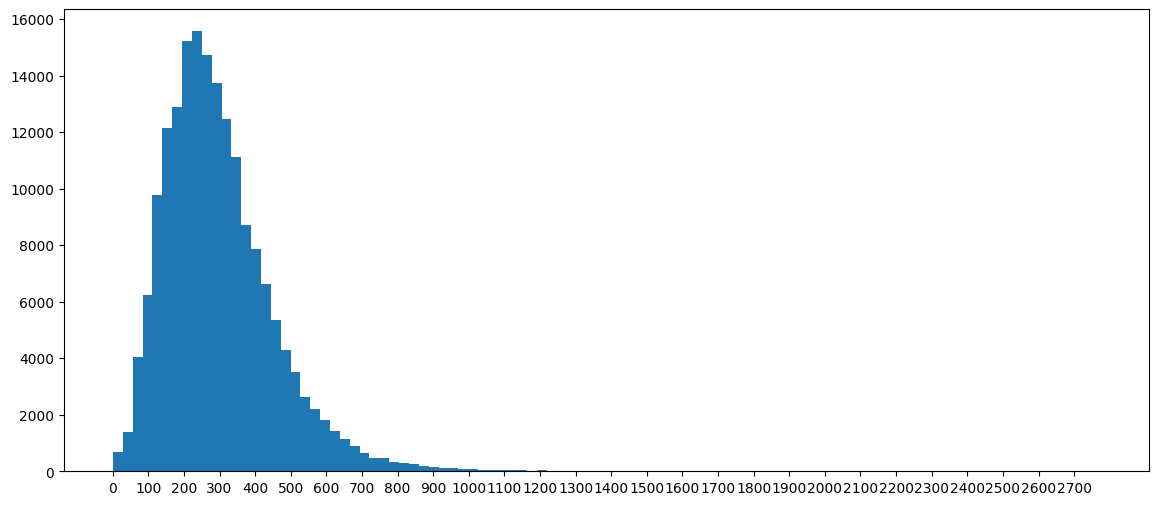

In [116]:
plt.figure(figsize=(14,6))
plt.hist(char_len, bins=100)
plt.xticks(np.arange(0,np.max(char_len),100))

In [117]:
np.sum(word_len)

4741942

In [118]:
np.sum(char_len)

53603762

In [119]:
# Get all keyboard characters
import string
alphabet= string.ascii_lowercase + string.digits + string.punctuation 
alphabet, len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [120]:
# Create char level token vectorizer instance
NUM_CHAR_TOKENS= len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer= TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_mode='int',
                                  output_sequence_length= int(char_len_q95),
                                  # standardize=None, # set standardization to "None" if you want to leave punctuation in
                                  name='char_vectorizer',
                                  )



In [121]:
NUM_CHAR_TOKENS

70

In [122]:
(char_len_q95)

579.0

In [123]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [124]:
# Check character vocab stats
char_vocab= char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab

(28,
 ['',
  '[UNK]',
  'e',
  't',
  'i',
  'a',
  'n',
  'o',
  'r',
  's',
  'd',
  'c',
  'l',
  'h',
  'p',
  'm',
  'u',
  'f',
  'g',
  'y',
  'w',
  'v',
  'b',
  'k',
  'x',
  'z',
  'q',
  'j'])

In [125]:
# Test out character vectorizer
random_sentence= random.choice(train_chars)
print(f'Text:\t(Shape: {len(random_sentence.split())})\n{random_sentence}')

random_sentence_vectorized=char_vectorizer(random_sentence)
print(f'\n\nRandm sentence after character vectorization:\t(Shape: {len(random_sentence_vectorized)})\n{random_sentence_vectorized}')

Text:	(Shape: 76)
u n i n t e n t i o n a l   o v e r d o s e   d e a t h s   i n v o l v i n g   p r e s c r i p t i o n   o p i o i d s   h a v e   q u a d r u p l e d   s i n c e   @   .


Randm sentence after character vectorization:	(Shape: 579)
[16  6  4  6  3  2  6  3  4  7  6  5 12  7 21  2  8 10  7  9  2 10  2  5
  3 13  9  4  6 21  7 12 21  4  6 18 14  8  2  9 11  8  4 14  3  4  7  6
  7 14  4  7  4 10  9 13  5 21  2 26 16  5 10  8 16 14 12  2 10  9  4  6
 11  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 

### Creating a character-level embedding

In [126]:
len(char_vectorizer.get_vocabulary())

28

In [127]:
char_embedding= Embedding(input_dim= len(char_vocab),
                         output_dim= 25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                         mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                         name= 'char_embedding')

In [128]:
# Test out character embedding
random_sentence= random.choice(train_chars)
print(f'Text:\t(Shape: {len(random_sentence.split())})\n{random_sentence}')

random_sentence_embedded=char_embedding(char_vectorizer(random_sentence))
print(f'\n\nRandm sentence after character vectorization:\t(Shape: {(random_sentence_embedded).shape})\n{random_sentence_embedded}')

Text:	(Shape: 177)
t h e   i n t e r v e n t i o n   w a s   m o r e   e f f e c t i v e   t h a n   u s u a l   c a r e   (   s h o r t - t e r m   d i a b e t e s   e d u c a t i o n   )   a t   i m p r o v i n g   g l y c e m i c   c o n t r o l   ,   b u t   n o t   w e i g h t   ,   i n   l o w - i n c o m e   a f r i c a n   a m e r i c a n s   w i t h   c o m o r b i d   d i a b e t e s   a n d   h y p e r t e n s i o n   .


Randm sentence after character vectorization:	(Shape: (579, 25))
[[-0.0139403  -0.04839521  0.04491781 ...  0.0088007  -0.03567537
   0.01115258]
 [-0.03442105  0.03955983  0.002581   ... -0.00748483  0.00118848
   0.01330994]
 [-0.00677912  0.0363686   0.03987478 ...  0.03006807 -0.02163336
   0.04373688]
 ...
 [-0.02090702 -0.03071876 -0.00188953 ... -0.02269254 -0.01028447
   0.0436447 ]
 [-0.02090702 -0.03071876 -0.00188953 ... -0.02269254 -0.01028447
   0.0436447 ]
 [-0.02090702 -0.03071876 -0.00188953 ... -0.02269254 -0.01028447
   0.0436447 ]]


In [129]:
random_sentence_embedded[0]

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([-0.0139403 , -0.04839521,  0.04491781,  0.03933039, -0.02733936,
       -0.0271776 , -0.04997639,  0.0263369 , -0.02731823, -0.0409567 ,
        0.01680222,  0.03763686, -0.03950872,  0.04621849,  0.02398172,
        0.01500913,  0.00173688,  0.02683312,  0.04601211, -0.02258561,
       -0.00548499, -0.03208037,  0.0088007 , -0.03567537,  0.01115258],
      dtype=float32)>

### Building a Conv1D model to fit on character embeddings


In [130]:
# Make Conv1D on chars only
inputs= tf.keras.layers.Input(shape=(1,), dtype=tf.string)
vectorizing= char_vectorizer(inputs)
embedding= char_embedding(vectorizing)
x= tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu')(embedding)
x= tf.keras.layers.GlobalMaxPool1D()(x)
outputs= tf_keras.layers.Dense(num_classes, activation='softmax')(x)
model_3= tf.keras.Model(inputs, outputs, name='model_3_Conv1D_char_embedding')

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [131]:
model_3.summary()

Model: "model_3_Conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 579)               0         
 rization)                                                       
                                                                 
 char_embedding (Embedding)  (None, 579, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 579, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [132]:
# Create character level dataser
train_char_dataset= tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset= tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset= tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [133]:
history_model_3= model_3.fit(train_char_dataset,
                             steps_per_epoch= int(.1 * len(train_char_dataset)),
                             epochs=3,
                             validation_data= val_char_dataset,
                             validation_steps= int(.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 27ms/step - loss: 1.2562 - accuracy: 0.4887 - val_loss: 1.0396 - val_accuracy: 0.5928
Epoch 2/3
562/562 [==============================] - 15s 27ms/step - loss: 1.0033 - accuracy: 0.5994 - val_loss: 0.9290 - val_accuracy: 0.6403
Epoch 3/3
562/562 [==============================] - 15s 26ms/step - loss: 0.9190 - accuracy: 0.6405 - val_loss: 0.8535 - val_accuracy: 0.6809


In [134]:
model_3.evaluate(test_char_dataset)

942/942 [==============================] - 7s 7ms/step - loss: 0.8895 - accuracy: 0.6543


[0.8894991278648376, 0.6542558670043945]

In [135]:
model_3_pred_probs= model_3.predict(test_char_dataset)

942/942 [==============================] - 7s 7ms/step


In [136]:
model_3_preds= tf.argmax(model_3_pred_probs, axis=1)

In [137]:
model_3_results= calculate_results(test_labels_encoded, model_3_preds)
model_3_results

{'accuracy': 65.42558486809358,
 'precision': 0.6479299557827728,
 'recall': 0.6542558486809358,
 'f1': 0.6429193595768494}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (`similar model_2`)
2. Create a character-level model (`similar to model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [138]:
# 1. Setup token inputs/model
token_inputs= layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings= tf_hub_embedding_layer(token_inputs)
token_outputs= layers.Dense(128, activation='relu')(token_embeddings)
token_model= tf.keras.Model(inputs= token_inputs,
                           outputs= token_outputs)

# 2. Setup char inputs/model
char_inputs= tf.keras.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors= char_vectorizer(char_inputs)
char_embeddings= char_embedding(char_vectors)
char_bi_lstm= layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model= tf.keras.Model(inputs= char_inputs,
                           outputs= char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat= layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                char_model.output])

# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout= layers.Dropout(0.5)(token_char_concat)
combined_dense= layers.Dense(128, activation='relu')(combined_dropout)
final_dropout= layers.Dropout(0.5)(combined_dense)
output_layer= layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4= tf.keras.Model(inputs=[token_model.input, char_model.input],
                       outputs= output_layer,
                       name='model_4_token_and_char_embeddings')



In [139]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 579)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

In [140]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model

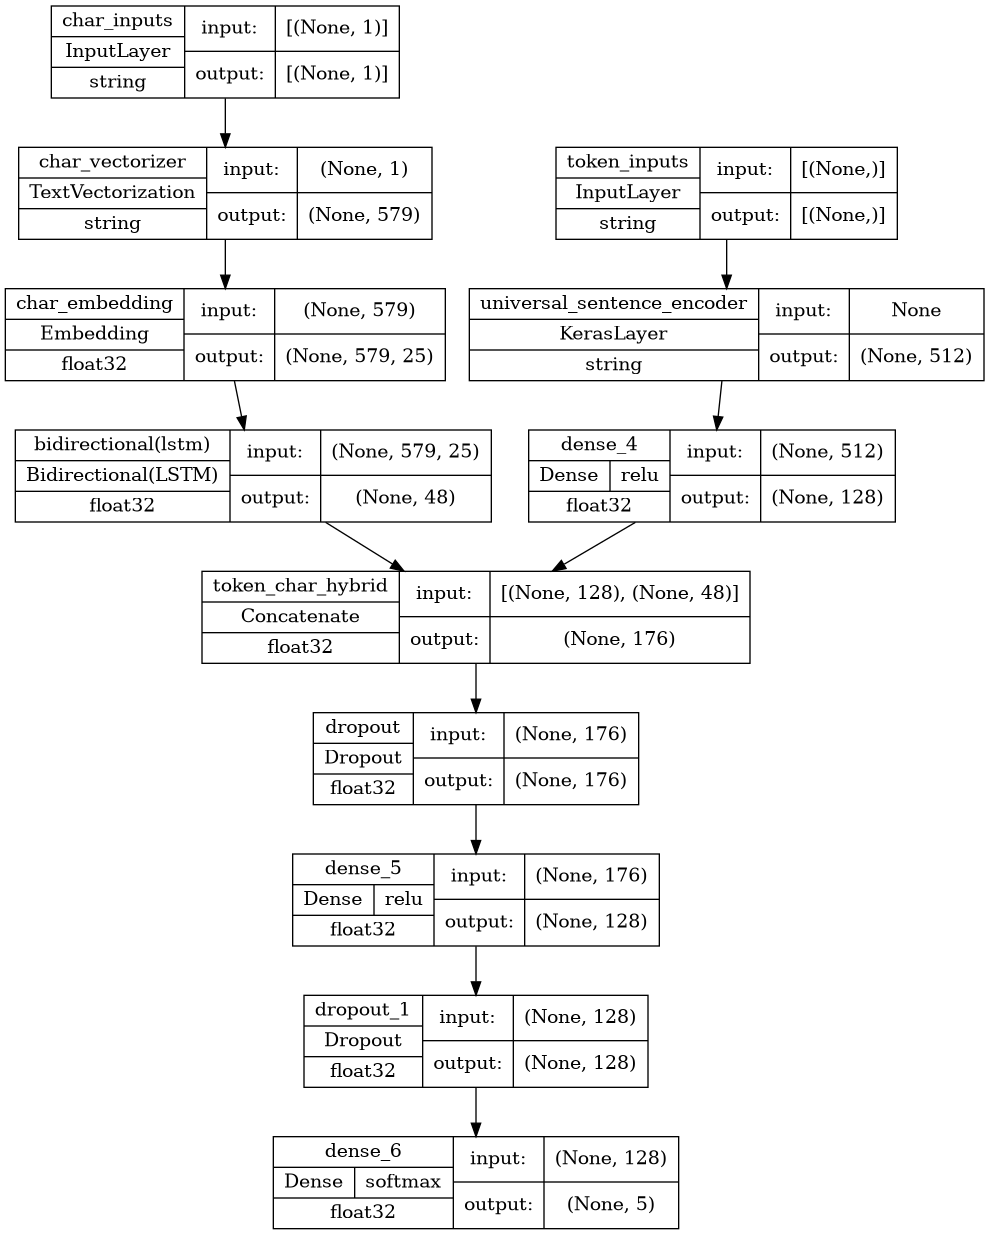

In [141]:
plot_model(model_4, show_dtype=True, show_layer_activations=True, show_shapes=True)

In [142]:
# Compile token and char hybrid model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says they use SGD, you might want to try this
               metrics=['accuracy'])

### Combining token and character into a tf.data.Dataset

In [143]:
# Combine chars and tokens into a dataset
train_token_char_data= tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels= tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset= tf.data.Dataset.zip(train_token_char_data, train_token_char_labels)

# Batch and prefetch dataset
train_token_char_dataset= train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [144]:
# For validation dataset
val_token_char_data= tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels= tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset= tf.data.Dataset.zip(val_token_char_data, val_token_char_labels)


val_token_char_dataset= val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [145]:
train_token_char_dataset, '', val_token_char_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 '',
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences


In [146]:
len(train_token_char_dataset)

5627

In [147]:
5627*32

180064

In [148]:
history_model_4= model_4.fit(train_token_char_dataset,
                            steps_per_epoch= int(.1 * len(train_token_char_dataset)),
                            epochs=3,
                            validation_data= val_token_char_dataset,
                            validation_steps= int(.1 * len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 127s 218ms/step - loss: 0.9804 - accuracy: 0.6117 - val_loss: 0.7835 - val_accuracy: 0.6938
Epoch 2/3
562/562 [==============================] - 121s 215ms/step - loss: 0.8069 - accuracy: 0.6903 - val_loss: 0.7230 - val_accuracy: 0.7234
Epoch 3/3
562/562 [==============================] - 121s 216ms/step - loss: 0.7795 - accuracy: 0.7013 - val_loss: 0.6969 - val_accuracy: 0.7344


In [149]:
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 50s 53ms/step - loss: 0.7021 - accuracy: 0.7327


[0.7020867466926575, 0.7326558828353882]

In [150]:
model_4_preds= tf.argmax(model_4.predict(val_token_char_dataset), axis=1)

945/945 [==============================] - 51s 53ms/step


In [151]:
model_4_results= calculate_results(val_labels_encoded, model_4_preds)
model_4_results

{'accuracy': 73.2655898318549,
 'precision': 0.7338079946382718,
 'recall': 0.7326558983185489,
 'f1': 0.7303937606280158}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [152]:
train_samples[:5]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [153]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


>🔑 Note: Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [154]:
train_df['line_number'].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

([<matplotlib.axis.XTick at 0x7fb322992300>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30')])

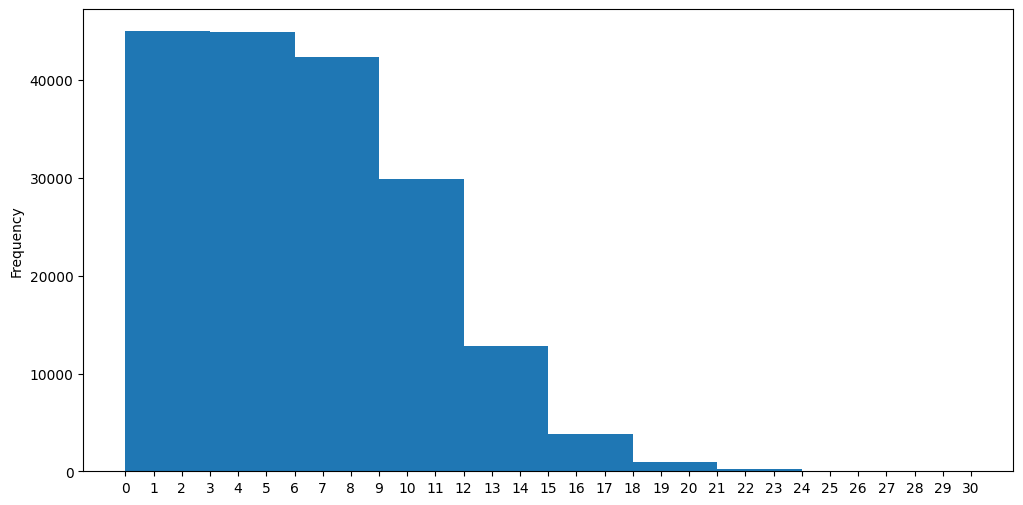

In [155]:
plt.figure(figsize=(12,6))
train_df.line_number.plot.hist(bins=10)
plt.xticks(np.arange(31))


In [156]:
np.percentile(train_df['line_number'], 98)

15.0

In [157]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_number_one_hot= tf.one_hot(train_df['line_number'], depth=15)
val_line_number_one_hot= tf.one_hot(val_df['line_number'], depth=15)
test_line_number_one_hot= tf.one_hot(test_df['line_number'], depth=15)

In [158]:
train_line_number_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [159]:
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

([<matplotlib.axis.XTick at 0x7fb323705280>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30')])

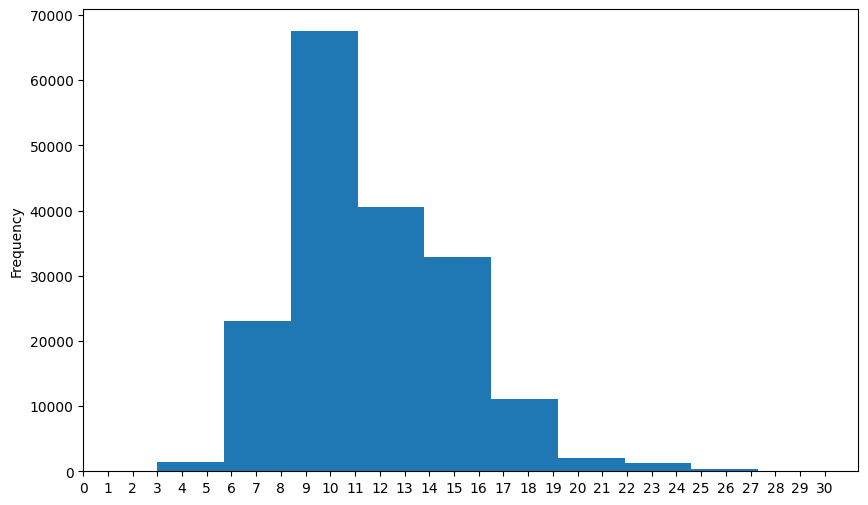

In [160]:
plt.figure(figsize=(10,6))
train_df['total_lines'].plot.hist(bins=10)
plt.xticks(range(31))

In [161]:
np.percentile(train_df['total_lines'], 98)

20.0

In [180]:
train_total_lines_one_hot= tf.one_hot(train_df['total_lines'], depth=20)
val_total_lines_one_hot= tf.one_hot(val_df['total_lines'], depth=20)
test_total_lines_onr_hot= tf.one_hot(test_df['total_lines'], depth=20)

In [171]:
train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [164]:
# 1. Token inputs
token_inputs= layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings= tf_hub_embedding_layer(token_inputs)
token_outputs= layers.Dense(128, activation='relu', name='token_outputs')(token_embeddings)
token_model= tf.keras.Model(inputs= token_inputs,
                           outputs= token_outputs)

# 2. Char inputs
char_inputs= layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors= char_vectorizer(char_inputs)
char_embeddings= char_embedding(char_vectors)
char_bi_lstm= layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model= tf.keras.Model(inputs= char_inputs,
                          outputs= char_bi_lstm)

# 3. Line number model
line_number_inputs= layers.Input(shape=(15,), dtype=tf.float32, name='line_number_inputs')
line_number_outputs= layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model= tf.keras.Model(line_number_inputs,
                                 line_number_outputs) 

# 4. Total lines model
total_lines_inputs= layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_inputs')
total_lines_outputs= layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model= tf.keras.Model(total_lines_inputs,
                                 total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings= layers.Concatenate(name='token_char_embedding')([token_model.output,
                                                                     char_model.output])

combined_dense= layers.Dense(256, activation='relu')(combined_embeddings)
combined_dropout= layers.Dropout(0.5)(combined_dense)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings= layers.Concatenate(name='token_char_positional_embedding')([line_number_model.output,
                                                                               total_lines_model.output,
                                                                               combined_dropout])

# 7. Create output layer
output_layer= layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5= tf.keras.Model(inputs=[line_number_model.input,
                               total_lines_model.input,
                               token_model.input,
                               char_model.input ],
                       outputs= output_layer,
                       name='model_5_tribrid_embedding')

In [165]:
model_5.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 579)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['toke

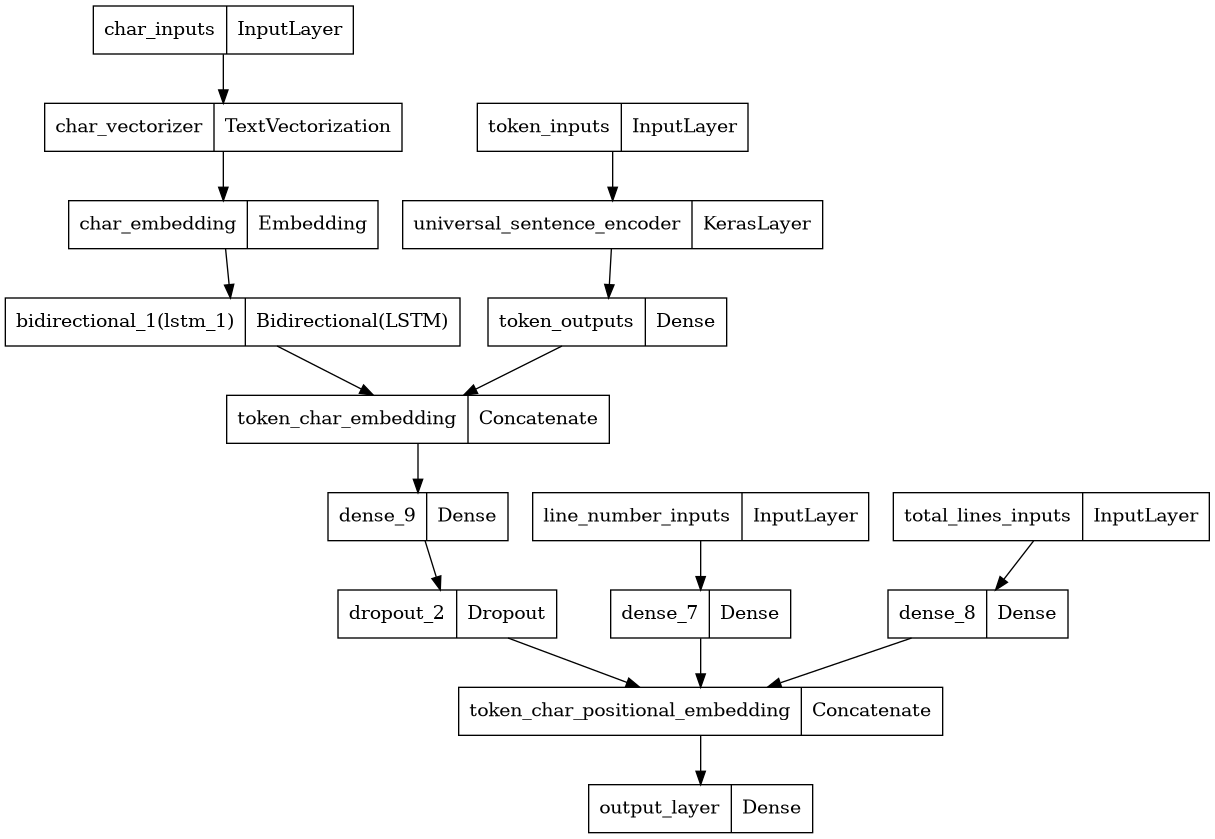

In [166]:
plot_model(model_5)

In [167]:
model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
               optimizer= tf.keras.optimizers.Adam(),
               metrics= ['accuracy'])

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

>📖 Resource: For more on label smoothing, see this blog post from PyImageSearch: https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

### Create tribrid embedding datasets using tf.data


In [168]:
train_line_number_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [182]:
# Create training and valiadation datasets (with all four kinds of input data)
train_token_char_pos_data= tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                              train_total_lines_one_hot,
                                                              train_sentences,
                                                              train_chars))

train_token_char_pos_labels= tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_pos_dataset= tf.data.Dataset.zip((train_token_char_pos_data, train_token_char_pos_labels))
train_token_char_pos_dataset= train_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above for validation dataset
val_token_char_pos_data= tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_token_char_pos_labels= tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_pos_dataset= tf.data.Dataset.zip((val_token_char_pos_data, val_token_char_pos_labels))
val_token_char_pos_dataset= val_token_char_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [196]:
train_token_char_pos_dataset, '', val_token_char_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 '',
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [194]:
a=train_token_char_pos_dataset.take(1)

In [195]:
list(a)

[((<tf.Tensor: shape=(32, 15), dtype=float32, numpy=
   array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [

### Fitting, evaluating and making predicitions with our tribrid model


In [197]:
history_model_5= model_5.fit(train_token_char_pos_dataset,
                            steps_per_epoch= int(.1*len(train_token_char_pos_dataset)),
                            epochs=3,
                            validation_data= val_token_char_pos_dataset,
                            validation_steps= int(.1*len(val_token_char_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 147s 252ms/step - loss: 1.0933 - accuracy: 0.7271 - val_loss: 0.9851 - val_accuracy: 0.8012
Epoch 2/3
562/562 [==============================] - 140s 249ms/step - loss: 0.9673 - accuracy: 0.8162 - val_loss: 0.9510 - val_accuracy: 0.8288
Epoch 3/3
562/562 [==============================] - 138s 246ms/step - loss: 0.9509 - accuracy: 0.8240 - val_loss: 0.9410 - val_accuracy: 0.8291


In [199]:
model_5_pred_probs= model_5.predict(val_token_char_pos_dataset)

945/945 [==============================] - 56s 58ms/step


In [200]:
model_5_preds= tf.argmax(model_5_pred_probs, axis=1)

In [202]:
model_5_results= calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 83.08619091751622,
 'precision': 0.8294327653788981,
 'recall': 0.8308619091751622,
 'f1': 0.8296434802010868}

## Compare model results

In [217]:
results_all_model= pd.DataFrame({'model_0_baseline':baseline_results,
                                'model_1_custom_token_embedding':model_1_results,
                                'model_2_pretrained_token_embedding':model_2_results,
                                'model_3_custom_char_embedding':model_3_results,
                                'model_4_hybrid_token_char_embedding':model_4_results,
                                'model_5_token_char_pos_embedding':model_5_results})

results_all_model= results_all_model.T
results_all_model

,accuracy,precision,recall,f1
model_0_baseline,71.667496,0.712432,0.716675,0.692510
model_1_custom_token_embedding,78.148333,0.778599,0.781483,0.779005
model_2_pretrained_token_embedding,70.817986,0.710649,0.708180,0.705574
model_3_custom_char_embedding,65.425585,0.647930,0.654256,0.642919
model_4_hybrid_token_char_embedding,73.265590,0.733808,0.732656,0.730394
model_5_token_char_pos_embedding,83.086191,0.829433,0.830862,0.829643


In [218]:
results_all_model['accuracy']= results_all_model['accuracy']/100
results_all_model

,accuracy,precision,recall,f1
model_0_baseline,0.716675,0.712432,0.716675,0.692510
model_1_custom_token_embedding,0.781483,0.778599,0.781483,0.779005
model_2_pretrained_token_embedding,0.708180,0.710649,0.708180,0.705574
model_3_custom_char_embedding,0.654256,0.647930,0.654256,0.642919
model_4_hybrid_token_char_embedding,0.732656,0.733808,0.732656,0.730394
model_5_token_char_pos_embedding,0.830862,0.829433,0.830862,0.829643


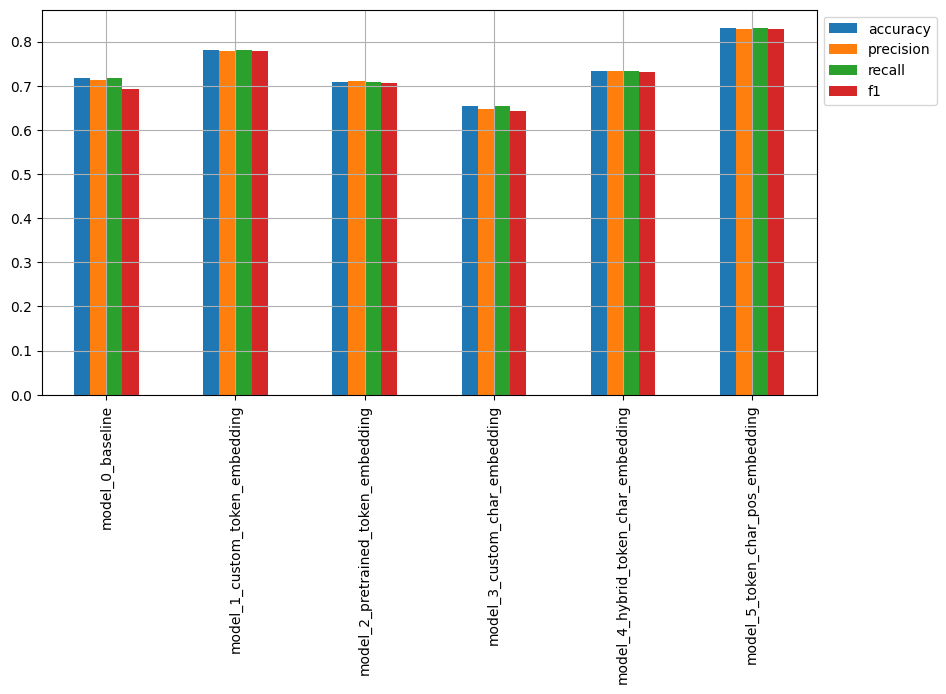

In [229]:
results_all_model.plot(kind='bar', figsize=(10,5)).legend(bbox_to_anchor=(1,1))
plt.grid()

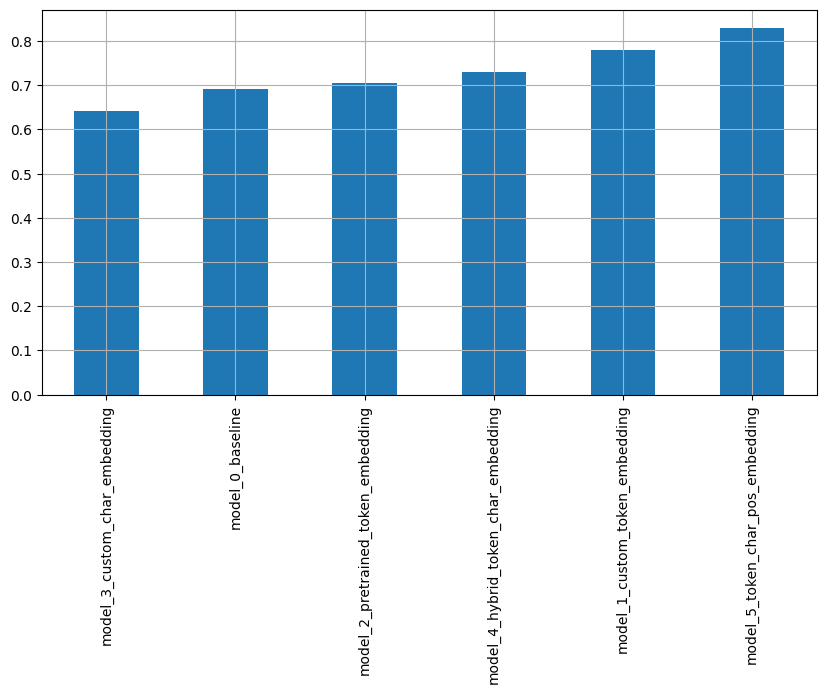

In [239]:
results_all_model['f1'].sort_values().plot(kind='bar', figsize=(10,5)).grid()

## Save and load model

In [276]:
model_5.save('Saved_models/skimlit_tribred_model', save_format='tf')

INFO:tensorflow:Assets written to: Saved_models/skimlit_tribred_model/assets


INFO:tensorflow:Assets written to: Saved_models/skimlit_tribred_model/assets


In [277]:
#loaded_model_5= tf.saved_model.load('Saved_models/saved_model_5.keras') 
loaded_model= tf.keras.models.load_model('Saved_models/skimlit_tribred_model') 

In [278]:
loaded_model

In [279]:
loaded_model_preds= tf.argmax(loaded_model_5.predict(val_token_char_pos_dataset), axis=1)
loaded_model_preds[:5]

945/945 [==============================] - 55s 58ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [280]:
loaded_model_results= calculate_results(val_labels_encoded, loaded_model_5_preds)
loaded_model_results

{'accuracy': 83.08619091751622,
 'precision': 0.8294327653788981,
 'recall': 0.8308619091751622,
 'f1': 0.8296434802010868}

In [281]:
model_5_results


{'accuracy': 83.08619091751622,
 'precision': 0.8294327653788981,
 'recall': 0.8308619091751622,
 'f1': 0.8296434802010868}

In [283]:
assert model_5_results == loaded_model_results

In [284]:
loaded_model.summary()

Model: "model_5_tribrid_embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 579)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['toke